## Analytical Report for the Stock Connect Program in China
Group 3, ZHANG, Jian (219012058), ZENG, Ying (219012027), HOANG, Nam Nguyen (219400001)

### I.  Introduction
We witness the stock price goes up and down and the trade volumes change frequently so we are eager to find out the inner logic and influence factors for the fluctuation. Moreover, some people claim that the higher liquidity, the higher probability to flourish the economic market. Stock Connect allows smaller trading firms and hedge funds to access A-share market, who cannot reach the requirements of the Qualified Investor programs, arousing global liquidity boost. The Stock Connect opens China's capital markets to international investors by providing access to mainland-listed A-shares and allows domestic investors to access stocks listed outside the Mainland. A Stock Connect programs as example is securities trading arrangements that link China's mainland stock exchanges to that of Hong Kong (SHSC on November 17,2014).


In [3]:
# import necessary library
import numpy as np
import pandas as pd
from highcharts import Highchart, Highstock
import datetime as dt
from linearmodels.panel import PanelOLS

In [4]:
# Read data from csv
HKG_09 = pd.read_csv('./Result/HKG201409.csv', parse_dates = ['date'])
HKG_10 = pd.read_csv('./Result/HKG201410.csv', parse_dates = ['date'])
HKG_11 = pd.read_csv('./Result/HKG201411.csv', parse_dates = ['date'])
HKG_12 = pd.read_csv('./Result/HKG201412.csv', parse_dates = ['date'])
HKG_01 = pd.read_csv('./Result/HKG201501.csv', parse_dates = ['date'])

SHH_09 = pd.read_csv('./Result/SHH201409.csv', parse_dates = ['date'])
SHH_10 = pd.read_csv('./Result/SHH201410.csv', parse_dates = ['date'])
SHH_11 = pd.read_csv('./Result/SHH201411.csv', parse_dates = ['date'])
SHH_12 = pd.read_csv('./Result/SHH201412.csv', parse_dates = ['date'])
SHH_01 = pd.read_csv('./Result/SHH201501.csv', parse_dates = ['date'])

### II. Data Management

#### Data cleaning

In order to seek the influence of stock connect, we obtained data from September 2014 to January 2015, covering the launch date of SHSC. We found that there are some testing data (contain 'z', 'mad', TEST', 'Y' in security name) and data dated on Saturday, which are duplicated or useless for our analysis so we excluded them via code ‘~shh_ref_df['RIC'].str.contains('xxx')’.

#### Data Group and Calculation

Then we calculate basic trading statistics (Total trade volume/value/count, Total quote count, Quote to trade ratio, Trade size), time-weighted quoted spread and value-weighted effective spread, intra-day volatility, order-to-trade ratio for Huatai Securities GDR and use code to find the examples of different types of entry. We use R-square, the p-value of F-statistic and confidence interval to confirm that our models are appropriate. As we want to find out the effect of stock connect, we divide data into two groups, one group as testing group is stocks joined SHSC and the other group as control group is stocks did not join SHSC, and check if they fluctuate significantly in statistic after the launch of SHSC.

In [5]:
# merge different months data
HKG_df = pd.concat([HKG_09, HKG_10, HKG_11, HKG_12, HKG_01], sort=False)
SHH_df = pd.concat([SHH_09, SHH_10, SHH_11, SHH_12, SHH_01], sort=False)

# exclude data contains 'z' in security name
SHH_df = SHH_df[~SHH_df['name'].str.contains('z')]

In [6]:
# calculate some metrics
HKG_df['quote_to_trade_ratio'] = (HKG_df['quote_count'] - HKG_df['trade_count']) / HKG_df['trade_count']
HKG_df['trade_size'] = HKG_df['trade_volume_count'] / HKG_df['trade_count']
HKG_df['time_weighted_qs'] = HKG_df['qs_value'] / HKG_df['qs_duration']

SHH_df['quote_to_trade_ratio'] = (SHH_df['quote_count'] - SHH_df['trade_count']) / SHH_df['trade_count']
SHH_df['trade_size'] = SHH_df['trade_volume_count'] / SHH_df['trade_count']
SHH_df['time_weighted_qs'] = SHH_df['qs_value'] / SHH_df['qs_duration']

In [7]:
# basic setting
pd.set_option('display.max_columns',None)

# overview of the reference dataset
path_data = '/ext/data/FA2019/Assignment/'
hkg_ref_df = pd.read_csv(path_data + '/HKG_ref.csv')
shh_ref_df = pd.read_csv(path_data + '/SHH_ref.csv')

# exclude data contains 'z', 'mad', TEST', 'Y' in security name
shh_ref_df = shh_ref_df[~shh_ref_df['RIC'].str.contains('z')]
shh_ref_df = shh_ref_df[~shh_ref_df['RIC'].str.contains('mad')]
shh_ref_df = shh_ref_df[~shh_ref_df['RIC'].str.contains('TEST')]
shh_ref_df = shh_ref_df[~shh_ref_df['RIC'].str.contains('Y')]

# read external data
sse_df = pd.read_csv('./data/SSE_Security.csv')
hkse_df = pd.read_csv('./data/HKSE_Security.csv')

In [8]:
# Shanghai-HongKong Stock Connect (SHSC)
SHSC_SHH_df = SHH_df.merge(sse_df, left_on='name', right_on='wind_code')
SHSC_SHH_df = SHSC_SHH_df.drop(['wind_code'], axis=1)

SHSC_HKG_df = HKG_df.merge(hkse_df, left_on='name', right_on='wind_code')
SHSC_HKG_df = SHSC_HKG_df.drop(['wind_code'], axis=1)

# NON SHSC
NON_SHSC_SHH_df = SHH_df.append(SHSC_SHH_df)
NON_SHSC_SHH_df = NON_SHSC_SHH_df.drop_duplicates(keep=False)

NON_SHSC_HKG_df = HKG_df.append(SHSC_HKG_df)
NON_SHSC_HKG_df = NON_SHSC_HKG_df.drop_duplicates(keep=False)

In [14]:
# Visualize with Highchart

# Default setting of Highchart
OPTIONS_DEFAULT = {
                  'chart': {'zoomType': 'x'},
                  'navigator': {'enabled': False},
                  'rangeSelector': {'enabled': False},
                  'legend': {'enabled': True,
                             'itemStyle':{'fontWeight':'normal'}}
                }

## bar chart option
options_column = OPTIONS_DEFAULT
options_column['title'] = {'text': 'trade volume versus trade value'}
options_column['yAxis'] = {'opposite': False}
options_column['xAxis'] = {'type': 'datetime'}
options_column['plotOptions'] = {'column':{'stacking':'value'}}


Column_Chart = Highstock()
Column_Chart.set_dict_options(options_column)

HKG_0001 = HKG_df[HKG_df['name'] == '0001.HK']
Column_Chart.add_data_set(HKG_0001.filter(['date','trade_value_count']).values.tolist(), name='value', type = 'column')
Column_Chart.add_data_set(HKG_0001.filter(['date','trade_volume_count']).values.tolist(), name='volume', type = 'column')

Column_Chart

In [15]:
def plotline(date, text):
    line = {
                'color': 'red',
                'width': 2,
                'value': ((date -  dt.datetime.utcfromtimestamp(0)).total_seconds() * 1000.0),
                'zIndex': 1,
                'label': {'text': text,
                            'style': {
                            'color': 'grey'},
                            'rotation': 90,
                            'align': 'center',
                            'x': 3,
                            'y': 50}
            }
    return line

### III. Analysis

Effect of launch and reasons

From the bar chart for daily trade volume and value, the trade volume and value were stable after the SHSC launch date. Set the trade volume and value on November 14, 2014 as basis, they met a small peak on November 24 (third times for both trade volume and value), drop dramatically on December 24(one third for both trade volume and value) and then reached top on January 12, 2015 (ten times for both trade volume and value). The bloomy situation has not appeared because: 
- i) the opportunity of short-term arbitrary has gone, the price of some A+H stocks is higher than A stocks leading no extreme big valuation difference; 
- ii) Lots of financial institutes still waited for investment guidance issued by supervisor; 
- iii) familiarity for the rules and skills about investment in other market. 

After a period of analysis and the recovery of economy, which made investor believe the prediction of the bull market, the liquidity increase sharply in 2015.

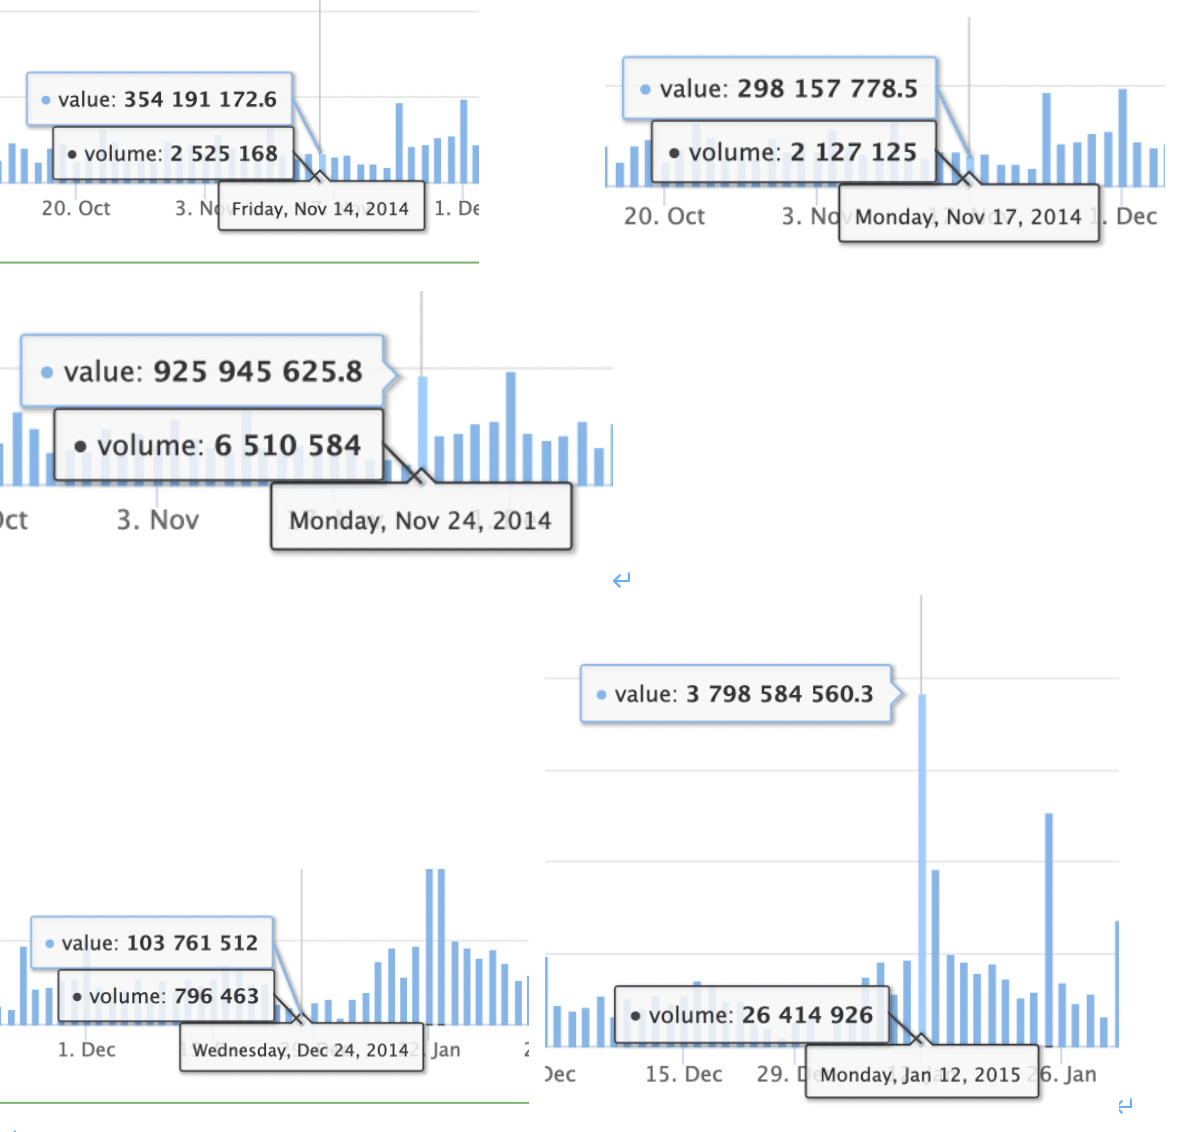

In [17]:
options_line = OPTIONS_DEFAULT
options_line['yAxis'] = [{'opposite': False, 'title':{'text': 'volume'},'tickAmount':8 },
                    {'opposite':True, 'title':{'text':'value'}, 'tickAmount':8}]

# event_dict = {'2015-01-12': 'Market Event 1', '2015-01-23': 'Market Event 2'}
# for date in event_dict:
#     date_object = dt.datetime.strptime(date, '%Y-%m-%d')
#     line = plotline(date_object, event_dict[date])
#     try:
#         options_line['xAxis']['plotLines'].append(line)
#     except KeyError:
#         options_line['xAxis']={'plotLines': [line]}

Line_Chart = Highstock()
Line_Chart.set_dict_options(options_line)

Line_Chart.add_data_set(HKG_0001.filter(['date','trade_volume_count']).values.tolist(), name='daily total trading volume', yAxis=0)
Line_Chart.add_data_set(HKG_0001.filter(['date','trade_value_count']).values.tolist(), name='daily total trading value', yAxis=1)

Line_Chart

#### Example -- stocks involved in SHSC

We also take the value trend of 600000.SS and 0001.HK as example, both are enrolled in the stock connect program, and it reveal that the SHSC provide more benefit to stocks in Shanghai, following the illustration earned from general comparison which compares testing group and control group in Shanghai and Hongkong separately.

In [19]:
# 600000.SS vs 0001.HK, both are enrolled in the stock connect program

options_line = OPTIONS_DEFAULT
options_line['yAxis'] = [{'opposite':False, 'title':{'text':'value'}, 'tickAmount':8}]
options_column['title'] = {'text': 'Value Trend of 600000.SS vs 0001.HK'}

event_dict = {'2014-11-17': 'Market Event 1'}
for date in event_dict:
    date_object = dt.datetime.strptime(date, '%Y-%m-%d')
    line = plotline(date_object, event_dict[date])
    try:
        options_line['xAxis']['plotLines'].append(line)
    except KeyError:
        options_line['xAxis']={'plotLines': [line]}

Line_Chart = Highstock()
Line_Chart.set_dict_options(options_line)

SHH_example = SHSC_SHH_df[SHSC_SHH_df['name'] == '600000.SS']
Line_Chart.add_data_set(SHH_example.filter(['date','trade_value_count']).values.tolist(), name='600000.SS', yAxis=0)
Line_Chart.add_data_set(HKG_0001.filter(['date','trade_value_count']).values.tolist(), name='0001.HK', yAxis=0)

Line_Chart

### III. Analysis

General view on effect on liquidity and volatility

The launched of stock connect has little effect on volatility but still has positive effect on the value, volumn and liquidity of stocks involved in stock connect. We will explain them one by one.


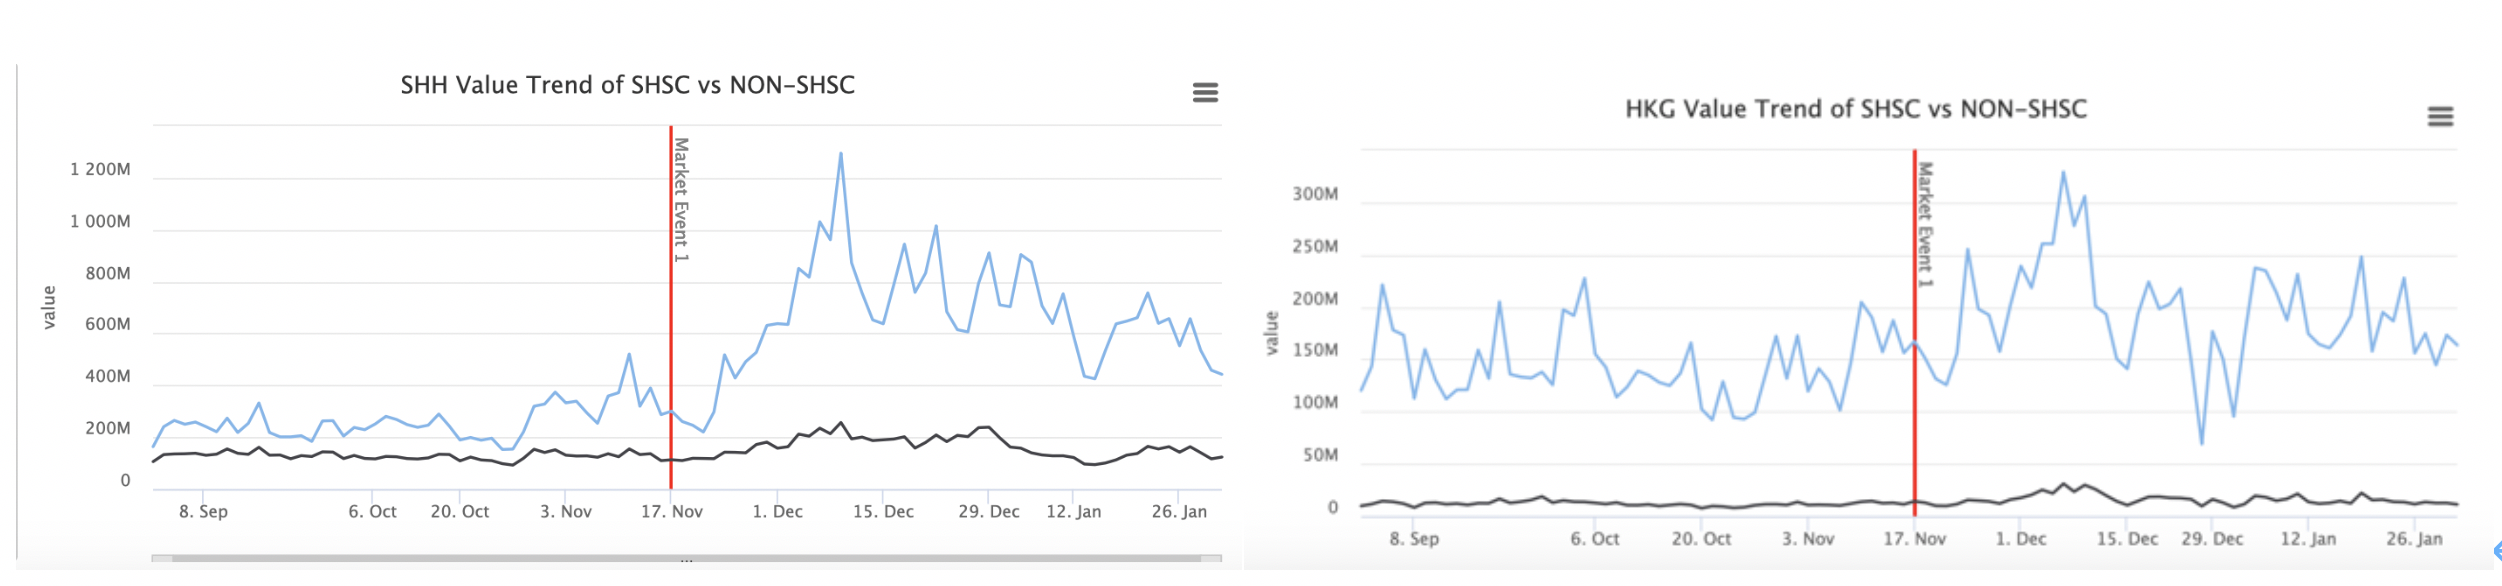

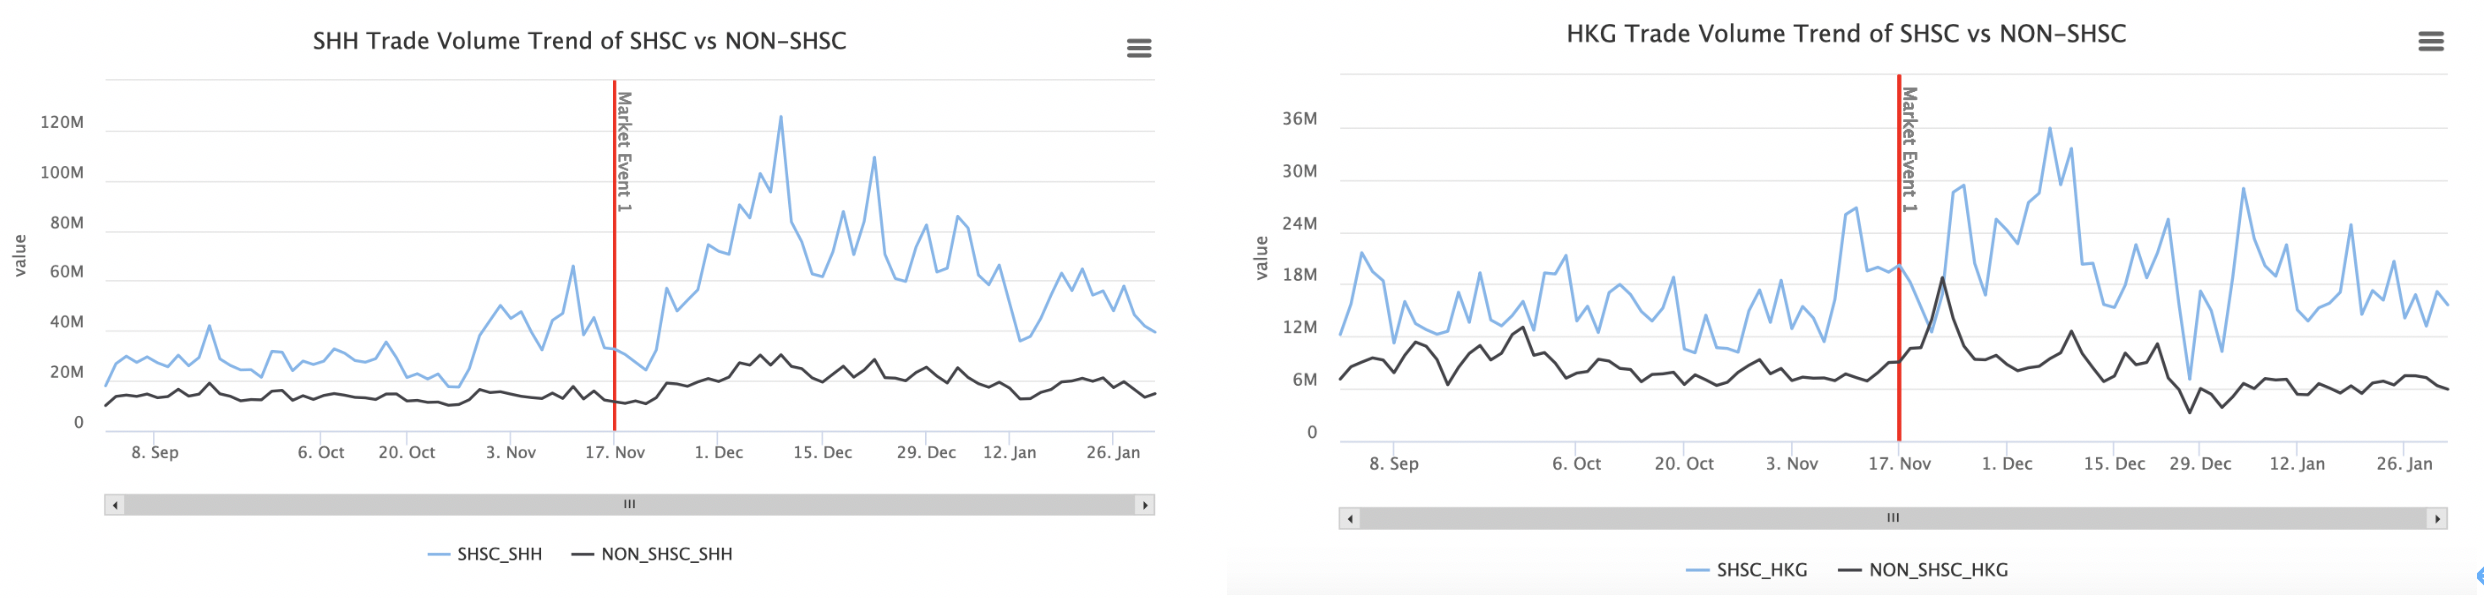

The trend of trade volume and value for stocks involved in stock connect fluctuates more significantly compared with those not involved. the stocks chosen as part of SHSC (blue line) are those who are more popular in investors’ view so their volume and value are both higher than those not chosen (black line).

For Shanghai Stock, the value and volume incline more steadily than Hongkong as Hongkong Stock Exchange is more opened than Shanghai Stock Exchange and it has already absorbed lots of foreign investors before SHSC launched. Thus, more foreign investors purchase Shanghai stocks at the period after the launched date. 


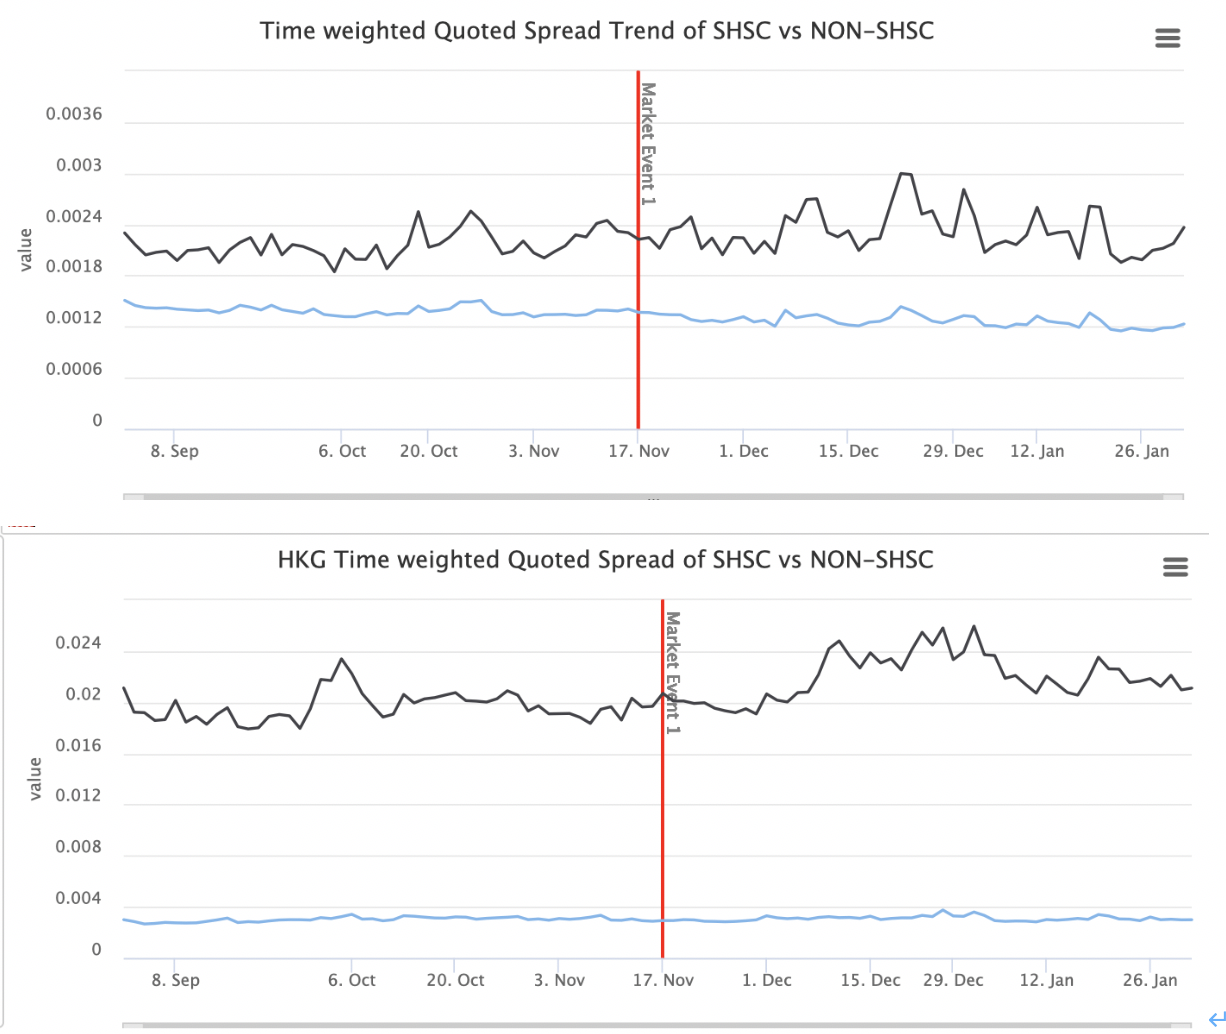

In both cases, the stocks included in the stock connect programs (blue line) have higher liquidity even before the launch of the programs. After the start, the difference between quoted spreads increases slightly, mainly driven by increased spreads for non-SHSC stocks. The quoted spreads of the SHSC stocks remain flat over the entire observed period while the spreads of the non-SHSC stocks seem to be more volatile.

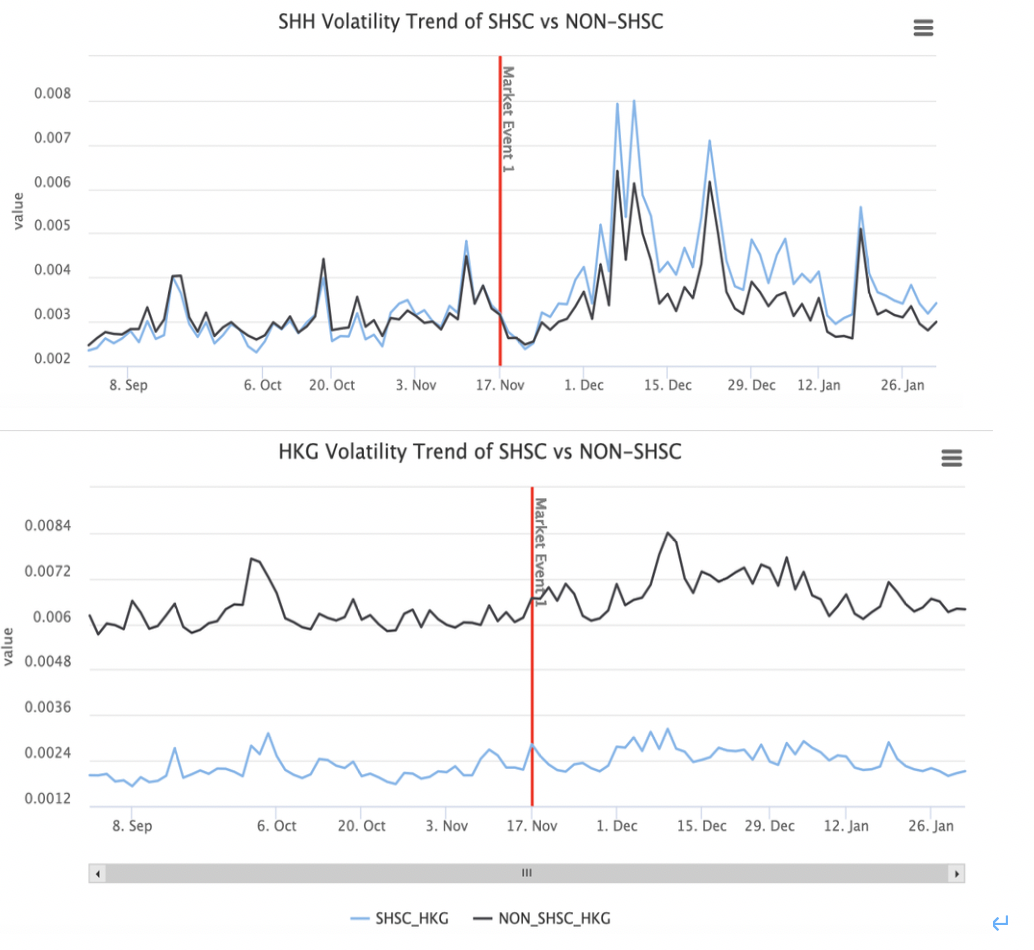

The SHSC has more influence on Shanghai stocks tham Hongkong stocks as the volatility upward damatically in December but the effect on test group and control group are smiliar. The difference for volatility in Hongkong stocks is larger than that in Shanghai, which might means that Hongkong stocks chosen in SHSC are more stable. In general, the launch of stock connect has little effect on volatility.

In [20]:
# Shanghai: stock enrolled in connect program vs stock not enrolled in connect program
# Value Trend

grouped_SHSC_SHH = SHSC_SHH_df.groupby(['date'], as_index=False).mean()
grouped_NON_SHSC_SHH = NON_SHSC_SHH_df.groupby(['date'], as_index=False).mean()

options_line = OPTIONS_DEFAULT
options_line['yAxis'] = [{'opposite':False, 'title':{'text':'value'}, 'tickAmount':8}]
options_column['title'] = {'text': 'SHH Value Trend of SHSC vs NON-SHSC'}

event_dict = {'2014-11-17': 'Market Event 1'}
for date in event_dict:
    date_object = dt.datetime.strptime(date, '%Y-%m-%d')
    line = plotline(date_object, event_dict[date])
    try:
        options_line['xAxis']['plotLines'].append(line)
    except KeyError:
        options_line['xAxis']={'plotLines': [line]}

Line_Chart = Highstock()
Line_Chart.set_dict_options(options_line)

Line_Chart.add_data_set(grouped_SHSC_SHH.filter(['date','trade_value_count']).values.tolist(), name='SHSC_SHH', yAxis=0)
Line_Chart.add_data_set(grouped_NON_SHSC_SHH.filter(['date','trade_value_count']).values.tolist(), name='NON_SHSC_SHH', yAxis=0)

Line_Chart

In [21]:
# SHH Trade Volume Trend
options_line = OPTIONS_DEFAULT
options_line['yAxis'] = [{'opposite':False, 'title':{'text':'value'}, 'tickAmount':8}]
options_column['title'] = {'text': 'SHH Trade Volume Trend of SHSC vs NON-SHSC'}

event_dict = {'2014-11-17': 'Market Event 1'}
for date in event_dict:
    date_object = dt.datetime.strptime(date, '%Y-%m-%d')
    line = plotline(date_object, event_dict[date])
    try:
        options_line['xAxis']['plotLines'].append(line)
    except KeyError:
        options_line['xAxis']={'plotLines': [line]}

Line_Chart = Highstock()
Line_Chart.set_dict_options(options_line)

Line_Chart.add_data_set(grouped_SHSC_SHH.filter(['date','trade_volume_count']).values.tolist(), name='SHSC_SHH', yAxis=0)
Line_Chart.add_data_set(grouped_NON_SHSC_SHH.filter(['date','trade_volume_count']).values.tolist(), name='NON_SHSC_SHH', yAxis=0)

Line_Chart

In [24]:
# Shanghai: stock enrolled in connect program vs stock not enrolled in connect program
# Volatility Trend

options_line = OPTIONS_DEFAULT
options_line['yAxis'] = [{'opposite':False, 'title':{'text':'value'}, 'tickAmount':8}]
options_column['title'] = {'text': 'SHH Volatility Trend of SHSC vs NON-SHSC'}

event_dict = {'2014-11-17': 'Market Event 1'}
for date in event_dict:
    date_object = dt.datetime.strptime(date, '%Y-%m-%d')
    line = plotline(date_object, event_dict[date])
    try:
        options_line['xAxis']['plotLines'].append(line)
    except KeyError:
        options_line['xAxis']={'plotLines': [line]}

Line_Chart = Highstock()
Line_Chart.set_dict_options(options_line)

Line_Chart.add_data_set(grouped_SHSC_SHH.filter(['date','volatility']).values.tolist(), name='SHSC_SHH', yAxis=0)
Line_Chart.add_data_set(grouped_NON_SHSC_SHH.filter(['date','volatility']).values.tolist(), name='NON_SHSC_SHH', yAxis=0)

Line_Chart

In [23]:
# Shanghai: stock enrolled in connect program vs stock not enrolled in connect program
# Time weighted Quoted Spread Trend

options_line = OPTIONS_DEFAULT
options_line['yAxis'] = [{'opposite':False, 'title':{'text':'value'}, 'tickAmount':8}]
options_column['title'] = {'text': 'Time weighted Quoted Spread Trend of SHSC vs NON-SHSC'}

event_dict = {'2014-11-17': 'Market Event 1'}
for date in event_dict:
    date_object = dt.datetime.strptime(date, '%Y-%m-%d')
    line = plotline(date_object, event_dict[date])
    try:
        options_line['xAxis']['plotLines'].append(line)
    except KeyError:
        options_line['xAxis']={'plotLines': [line]}

Line_Chart = Highstock()
Line_Chart.set_dict_options(options_line)

Line_Chart.add_data_set(grouped_SHSC_SHH.filter(['date','time_weighted_qs']).values.tolist(), name='SHSC_SHH', yAxis=0)
Line_Chart.add_data_set(grouped_NON_SHSC_SHH.filter(['date','time_weighted_qs']).values.tolist(), name='NON_SHSC_SHH', yAxis=0)

Line_Chart

In [26]:
# HongKong: stock enrolled in connect program vs stock not enrolled in connect program
# Value Trend

grouped_SHSC_HKG = SHSC_HKG_df.groupby(['date'], as_index=False).mean()
grouped_NON_SHSC_HKG = NON_SHSC_HKG_df.groupby(['date'], as_index=False).mean()

options_line = OPTIONS_DEFAULT
options_line['yAxis'] = [{'opposite':False, 'title':{'text':'value'}, 'tickAmount':8}]
options_column['title'] = {'text': 'HKG Value Trend of SHSC vs NON-SHSC'}

event_dict = {'2014-11-17': 'Market Event 1'}
for date in event_dict:
    date_object = dt.datetime.strptime(date, '%Y-%m-%d')
    line = plotline(date_object, event_dict[date])
    try:
        options_line['xAxis']['plotLines'].append(line)
    except KeyError:
        options_line['xAxis']={'plotLines': [line]}

Line_Chart = Highstock()
Line_Chart.set_dict_options(options_line)

Line_Chart.add_data_set(grouped_SHSC_HKG.filter(['date','trade_value_count']).values.tolist(), name='SHSC_HKG', yAxis=0)
Line_Chart.add_data_set(grouped_NON_SHSC_HKG.filter(['date','trade_value_count']).values.tolist(), name='NON_SHSC_HKG', yAxis=0)

Line_Chart

In [27]:
options_line = OPTIONS_DEFAULT
options_line['yAxis'] = [{'opposite':False, 'title':{'text':'value'}, 'tickAmount':8}]
options_column['title'] = {'text': 'HKG Trade Volume Trend of SHSC vs NON-SHSC'}

event_dict = {'2014-11-17': 'Market Event 1'}
for date in event_dict:
    date_object = dt.datetime.strptime(date, '%Y-%m-%d')
    line = plotline(date_object, event_dict[date])
    try:
        options_line['xAxis']['plotLines'].append(line)
    except KeyError:
        options_line['xAxis']={'plotLines': [line]}

Line_Chart = Highstock()
Line_Chart.set_dict_options(options_line)

Line_Chart.add_data_set(grouped_SHSC_HKG.filter(['date','trade_volume_count']).values.tolist(), name='SHSC_HKG', yAxis=0)
Line_Chart.add_data_set(grouped_NON_SHSC_HKG.filter(['date','trade_volume_count']).values.tolist(), name='NON_SHSC_HKG', yAxis=0)

Line_Chart

In [30]:
# HongKong: stock enrolled in connect program vs stock not enrolled in connect program
# Volatility Trend

options_line = OPTIONS_DEFAULT
options_line['yAxis'] = [{'opposite':False, 'title':{'text':'value'}, 'tickAmount':8}]
options_column['title'] = {'text': 'HKG Volatility Trend of SHSC vs NON-SHSC'}

event_dict = {'2014-11-17': 'Market Event 1'}
for date in event_dict:
    date_object = dt.datetime.strptime(date, '%Y-%m-%d')
    line = plotline(date_object, event_dict[date])
    try:
        options_line['xAxis']['plotLines'].append(line)
    except KeyError:
        options_line['xAxis']={'plotLines': [line]}

Line_Chart = Highstock()
Line_Chart.set_dict_options(options_line)

Line_Chart.add_data_set(grouped_SHSC_HKG.filter(['date','volatility']).values.tolist(), name='SHSC_HKG', yAxis=0)
Line_Chart.add_data_set(grouped_NON_SHSC_HKG.filter(['date','volatility']).values.tolist(), name='NON_SHSC_HKG', yAxis=0)

Line_Chart

In [29]:
# HongKong: stock enrolled in connect program vs stock not enrolled in connect program
# Time weighted Quoted Spread Trend

options_line = OPTIONS_DEFAULT
options_line['yAxis'] = [{'opposite':False, 'title':{'text':'value'}, 'tickAmount':8}]
options_column['title'] = {'text': 'HKG Time weighted Quoted Spread of SHSC vs NON-SHSC'}

event_dict = {'2014-11-17': 'Market Event 1'}
for date in event_dict:
  

#### DID analysis

To further discover the effect of the launch of stock connect, we used difference in difference (“DID”) model to find the relationship. The fix panel data are divided into test group and control group following previous grouping and the entity effect and time effect are set as true in this situation. 

The testing group and significant change after launched date are set as dummy equals to 1 and the opposite as dummy equals to 0. For DID analysis, volatility, time weighted quoted spread and trade volume count were set as y both in Shanghai and Hongkong stock market separately. 

#### Results and interpretation

In these models, all of the p-value for F-statistic are small (less than 0.0001). The launch of stock connect has greater effect on time weighted quoted spread and volatility in HongKong as R-square is 0.4 and 0.3 respectively. Per refer to the parameter and the other estimation summary, the launch of stock connect has positive influence on volatility and negative effect on time weighted quoted spread in Shanghai. On the contrary, The launch of stock connect has negative effect on volatility and time weighted quoted spread in Hongkong.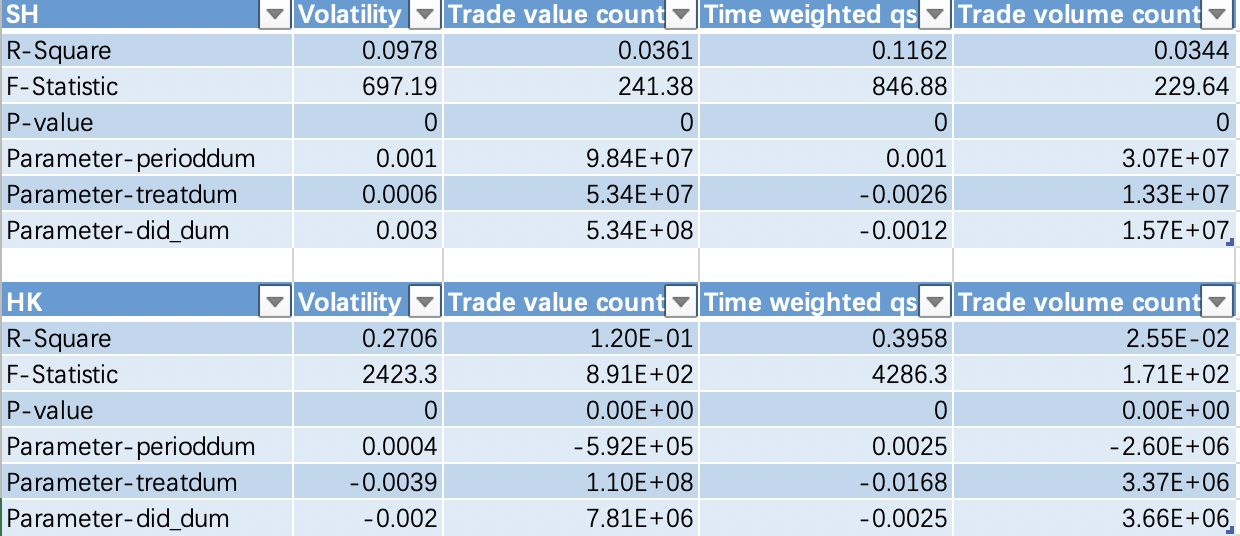

In [31]:
# DID analysis
# market event time: 14.11.17

# Shanghai volatility DID
SHSC_SHH_df['treatdum'] = 1
SHSC_SHH_df['id'] = pd.factorize(SHSC_SHH_df['name'])[0]
NON_SHSC_SHH_df['treatdum'] = 0
NON_SHSC_SHH_df['id'] = pd.factorize(NON_SHSC_SHH_df['name'])[0]

did_shh_df = pd.concat([SHSC_SHH_df, NON_SHSC_SHH_df])
# choose number of sample did
number = 100
did_shh_df = did_shh_df[did_shh_df.id < number]

did_shh_df.loc[did_shh_df['date']<=pd.datetime(2014,11,17), 'perioddum'] = 0
did_shh_df.loc[did_shh_df['date']>pd.datetime(2014,11,17), 'perioddum'] = 1

did_shh_df = did_shh_df.set_index(['id', 'date'])
did_shh_df['did_dum'] = did_shh_df['perioddum']*did_shh_df['treatdum']

x_variables = ['perioddum', 'treatdum', 'did_dum']
y_variable = 'volatility'

regression=PanelOLS(did_shh_df[y_variable], did_shh_df[x_variables], entity_effects=True, drop_absorbed=True)
regression.fit()

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:             volatility   R-squared:                        0.0978
Estimator:                   PanelOLS   R-squared (Between):              0.4391
No. Observations:               19400   R-squared (Within):               0.0978
Date:                Sun, Nov 24 2019   R-squared (Overall):              0.3379
Time:                        03:26:40   Log-likelihood                 9.253e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      697.19
Entities:                         100   P-value                           0.0000
Avg Obs:                       194.00   Distribution:                 F(3,19297)
Min Obs:                       107.00                                           
Max Obs:                       204.00   F-statistic (robust):             697.19
                                        P-value                           0.0000
Time periods:                     102   Distribution:                 F(3,19297)
Avg Obs:                       190.20                                           
Min Obs:                       185.00                                           
Max Obs:                       197.00                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
perioddum      0.0010  4.243e-05     23.169     0.0000      0.0009      0.0011
treatdum       0.0006  4.227e-05     13.243     0.0000      0.0005      0.0006
did_dum        0.0003  5.922e-05     5.0430     0.0000      0.0002      0.0004
==============================================================================

F-test for Poolability: 25.012
P-value: 0.0000
Distribution: F(99,19297)

Included effects: Entity
PanelEffectsResults, id: 0x7f5c77fa1898

In [32]:
# Shanghai trade value DID
x_variables = ['perioddum', 'treatdum', 'did_dum']
y_variable = 'trade_value_count'

regression=PanelOLS(did_shh_df[y_variable], did_shh_df[x_variables], entity_effects=True, drop_absorbed=True)
regression.fit()

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:      trade_value_count   R-squared:                        0.0361
Estimator:                   PanelOLS   R-squared (Between):              0.1330
No. Observations:               19428   R-squared (Within):               0.0361
Date:                Sun, Nov 24 2019   R-squared (Overall):              0.0703
Time:                        03:27:04   Log-likelihood                -4.374e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      241.38
Entities:                         100   P-value                           0.0000
Avg Obs:                       194.28   Distribution:                 F(3,19325)
Min Obs:                       107.00                                           
Max Obs:                       204.00   F-statistic (robust):             241.38
                                        P-value                           0.0000
Time periods:                     102   Distribution:                 F(3,19325)
Avg Obs:                       190.47                                           
Min Obs:                       186.00                                           
Max Obs:                       197.00                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
perioddum   9.841e+07  2.992e+07     3.2888     0.0010   3.976e+07   1.571e+08
treatdum    5.338e+07  2.981e+07     1.7905     0.0734  -5.057e+06   1.118e+08
did_dum      5.34e+08  4.178e+07     12.781     0.0000   4.521e+08   6.159e+08
==============================================================================

F-test for Poolability: 90.620
P-value: 0.0000
Distribution: F(99,19325)

Included effects: Entity
PanelEffectsResults, id: 0x7f5c78095cf8

In [301]:
# Shanghai time_weighted quoted spread DID
x_variables = ['perioddum', 'treatdum', 'did_dum']
y_variable = 'time_weighted_qs'

regression=PanelOLS(did_shh_df[y_variable], did_shh_df[x_variables], entity_effects=True, drop_absorbed=True)
regression.fit()

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:       time_weighted_qs   R-squared:                        0.1162
Estimator:                   PanelOLS   R-squared (Between):             -0.4346
No. Observations:               19428   R-squared (Within):               0.1162
Date:                Sat, Nov 23 2019   R-squared (Overall):             -0.1275
Time:                        11:48:04   Log-likelihood                 7.711e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      846.88
Entities:                         100   P-value                           0.0000
Avg Obs:                       194.28   Distribution:                 F(3,19325)
Min Obs:                       107.00                                           
Max Obs:                       204.00   F-statistic (robust):             846.88
                                        P-value                           0.0000
Time periods:                     102   Distribution:                 F(3,19325)
Avg Obs:                       190.47                                           
Min Obs:                       186.00                                           
Max Obs:                       197.00                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
perioddum      0.0010  9.437e-05     10.821     0.0000      0.0008      0.0012
treatdum      -0.0026  9.403e-05    -28.096     0.0000     -0.0028     -0.0025
did_dum       -0.0012     0.0001    -9.4752     0.0000     -0.0015     -0.0010
==============================================================================

F-test for Poolability: 94.748
P-value: 0.0000
Distribution: F(99,19325)

Included effects: Entity
PanelEffectsResults, id: 0x7f19a0fa5240

In [21]:
# Shanghai volume
x_variables = ['perioddum', 'treatdum', 'did_dum']
y_variable = 'trade_volume_count'

regression=PanelOLS(did_shh_df[y_variable], did_shh_df[x_variables], entity_effects=True, drop_absorbed=True)
regression.fit()

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:     trade_volume_count   R-squared:                        0.0344
Estimator:                   PanelOLS   R-squared (Between):              0.2147
No. Observations:               19428   R-squared (Within):               0.0344
Date:                Sun, Nov 24 2019   R-squared (Overall):              0.1056
Time:                        03:13:49   Log-likelihood                -3.888e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      229.64
Entities:                         100   P-value                           0.0000
Avg Obs:                       194.28   Distribution:                 F(3,19325)
Min Obs:                       107.00                                           
Max Obs:                       204.00   F-statistic (robust):             229.64
                                        P-value                           0.0000
Time periods:                     102   Distribution:                 F(3,19325)
Avg Obs:                       190.47                                           
Min Obs:                       186.00                                           
Max Obs:                       197.00                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
perioddum   3.065e+07  2.455e+06     12.486     0.0000   2.584e+07   3.547e+07
treatdum    1.326e+07  2.446e+06     5.4186     0.0000   8.461e+06   1.805e+07
did_dum     1.568e+07  3.428e+06     4.5732     0.0000   8.959e+06    2.24e+07
==============================================================================

F-test for Poolability: 97.796
P-value: 0.0000
Distribution: F(99,19325)

Included effects: Entity
PanelEffectsResults, id: 0x7f5c78095ba8

In [9]:
# HongKong volatility DID
SHSC_HKG_df['treatdum'] = 1
SHSC_HKG_df['id'] = pd.factorize(SHSC_HKG_df['name'])[0]
NON_SHSC_HKG_df['treatdum'] = 0
NON_SHSC_HKG_df['id'] = pd.factorize(NON_SHSC_HKG_df['name'])[0]

did_hkg_df = pd.concat([SHSC_HKG_df, NON_SHSC_HKG_df])
# choose number of sample did
number = 100
did_hkg_df = did_hkg_df[did_hkg_df.id < number]

did_hkg_df.loc[did_hkg_df['date']<=pd.datetime(2014,11,17), 'perioddum'] = 0
did_hkg_df.loc[did_hkg_df['date']>pd.datetime(2014,11,17), 'perioddum'] = 1

did_hkg_df = did_hkg_df.set_index(['id', 'date'])
did_hkg_df['did_dum'] = did_hkg_df['perioddum']*did_hkg_df['treatdum']

x_variables = ['perioddum', 'treatdum', 'did_dum']
y_variable = 'volatility'

regression=PanelOLS(did_hkg_df[y_variable], did_hkg_df[x_variables], entity_effects=True, drop_absorbed=True)
regression.fit()

/usr/local/lib/python3.6/dist-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:             volatility   R-squared:                        0.2706
Estimator:                   PanelOLS   R-squared (Between):             -1.0838
No. Observations:               19701   R-squared (Within):               0.2706
Date:                Wed, Nov 27 2019   R-squared (Overall):             -0.4645
Time:                        08:32:50   Log-likelihood                 8.469e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2423.3
Entities:                         100   P-value                           0.0000
Avg Obs:                       197.01   Distribution:                 F(3,19598)
Min Obs:                       133.00                                           
Max Obs:                       208.00   F-statistic (robust):             2423.3
                                        P-value                           0.0000
Time periods:                     104   Distribution:                 F(3,19598)
Avg Obs:                       189.43                                           
Min Obs:                       174.00                                           
Max Obs:                       196.00                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
perioddum      0.0004  6.832e-05     5.3756     0.0000      0.0002      0.0005
treatdum      -0.0039  6.615e-05    -59.098     0.0000     -0.0040     -0.0038
did_dum       -0.0002  9.409e-05    -2.3829     0.0172     -0.0004  -3.978e-05
==============================================================================

F-test for Poolability: 47.843
P-value: 0.0000
Distribution: F(99,19598)

Included effects: Entity
PanelEffectsResults, id: 0x7f032ba8b6a0

In [10]:
# HongKong trade value DID
x_variables = ['perioddum', 'treatdum', 'did_dum']
y_variable = 'trade_value_count'

regression=PanelOLS(did_hkg_df[y_variable], did_hkg_df[x_variables], entity_effects=True, drop_absorbed=True)
regression.fit()

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:      trade_value_count   R-squared:                        0.1198
Estimator:                   PanelOLS   R-squared (Between):              0.2481
No. Observations:               19737   R-squared (Within):               0.1198
Date:                Wed, Nov 27 2019   R-squared (Overall):              0.1669
Time:                        08:32:59   Log-likelihood                    -4e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      890.67
Entities:                         100   P-value                           0.0000
Avg Obs:                       197.37   Distribution:                 F(3,19634)
Min Obs:                       134.00                                           
Max Obs:                       208.00   F-statistic (robust):             890.67
                                        P-value                           0.0000
Time periods:                     104   Distribution:                 F(3,19634)
Avg Obs:                       189.78                                           
Min Obs:                       174.00                                           
Max Obs:                       196.00                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
perioddum  -5.915e+05  3.176e+06    -0.1862     0.8523  -6.817e+06   5.634e+06
treatdum    1.097e+08  3.076e+06     35.656     0.0000   1.037e+08   1.157e+08
did_dum     7.807e+06  4.378e+06     1.7832     0.0746  -7.743e+05   1.639e+07
==============================================================================

F-test for Poolability: 104.58
P-value: 0.0000
Distribution: F(99,19634)

Included effects: Entity
PanelEffectsResults, id: 0x7f0328e0c9e8

In [305]:
# HongKong time_weighted quoted spread DID
x_variables = ['perioddum', 'treatdum', 'did_dum']
y_variable = 'time_weighted_qs'

regression=PanelOLS(did_hkg_df[y_variable], did_hkg_df[x_variables], entity_effects=True, drop_absorbed=True)
regression.fit()

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:       time_weighted_qs   R-squared:                        0.3958
Estimator:                   PanelOLS   R-squared (Between):             -1.5792
No. Observations:               19734   R-squared (Within):               0.3958
Date:                Sat, Nov 23 2019   R-squared (Overall):             -0.4834
Time:                        11:51:45   Log-likelihood                 6.072e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4286.3
Entities:                         100   P-value                           0.0000
Avg Obs:                       197.34   Distribution:                 F(3,19631)
Min Obs:                       133.00                                           
Max Obs:                       208.00   F-statistic (robust):             4286.3
                                        P-value                           0.0000
Time periods:                     104   Distribution:                 F(3,19631)
Avg Obs:                       189.75                                           
Min Obs:                       174.00                                           
Max Obs:                       196.00                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
perioddum      0.0025     0.0002     10.798     0.0000      0.0020      0.0030
treatdum      -0.0168     0.0002    -75.137     0.0000     -0.0173     -0.0164
did_dum       -0.0025     0.0003    -7.8911     0.0000     -0.0031     -0.0019
==============================================================================

F-test for Poolability: 67.365
P-value: 0.0000
Distribution: F(99,19631)

Included effects: Entity
PanelEffectsResults, id: 0x7f19a0f55828

In [23]:
# HongKong Volume
x_variables = ['perioddum', 'treatdum', 'did_dum']
y_variable = 'trade_volume_count'

regression=PanelOLS(did_hkg_df[y_variable], did_hkg_df[x_variables], entity_effects=True, drop_absorbed=True)
regression.fit()

PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:     trade_volume_count   R-squared:                        0.0255
Estimator:                   PanelOLS   R-squared (Between):              0.1160
No. Observations:               19737   R-squared (Within):               0.0255
Date:                Sun, Nov 24 2019   R-squared (Overall):              0.0578
Time:                        03:17:35   Log-likelihood                -3.566e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      171.00
Entities:                         100   P-value                           0.0000
Avg Obs:                       197.37   Distribution:                 F(3,19634)
Min Obs:                       134.00                                           
Max Obs:                       208.00   F-statistic (robust):             171.00
                                        P-value                           0.0000
Time periods:                     104   Distribution:                 F(3,19634)
Avg Obs:                       189.78                                           
Min Obs:                       174.00                                           
Max Obs:                       196.00                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
perioddum  -2.602e+06  3.526e+05    -7.3792     0.0000  -3.293e+06  -1.911e+06
treatdum     3.37e+06  3.415e+05     9.8703     0.0000   2.701e+06    4.04e+06
did_dum     3.655e+06   4.86e+05     7.5214     0.0000   2.703e+06   4.608e+06
==============================================================================

F-test for Poolability: 76.179
P-value: 0.0000
Distribution: F(99,19634)

Included effects: Entity
PanelEffectsResults, id: 0x7f5c77fdfe48

### IV. Conclusion

Generally, the stock connect program has little effect on volatility but has positive influence on liquidity in both Shanghai and Hongkong stock market, increasing the stocks’ value, earnings for Exchange and securities companies (commission fee and stamps due to higher trade volume) and confidence of investors. This gives us an answer to the fundamental question that underlies our analysis: indeed, the stock connect programs that can be considered measures to promote and enhance an 'Market Liberalisation' and an 'Open Market' seem to have a positive effect on market quality as they have a negative effect on volatility as well as time weighted quoted spread in Hongkong and negative effect on the time weighted quoted spread in Shanghai.  
